In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [9]:
#files on disk
scores_file_train = 'avec_training.csv'
scores_file_dev = 'avec_development.csv'

features_file_train = 'features_train.csv'
features_file_dev = 'features_dev.csv'

time_file_train = 'transcript_times_train.csv'
time_file_dev = 'transcript_times_dev.csv'

pos_neg_words_file_train = 'pos_neg_counts_train.csv'
pos_neg_words_file_dev = 'pos_neg_counts_dev.csv'

#load files
scores_train = pd.read_csv(scores_file_train, index_col=0)
scores_dev = pd.read_csv(scores_file_dev, index_col=0)

#reset scores index
scores_dev.reset_index(drop=True, inplace=True)

#load in features file
features_train = pd.read_csv(features_file_train, sep='\t', index_col=0)
features_dev = pd.read_csv(features_file_dev, sep='\t', index_col=0)

#load in time metrics file
time_train = pd.read_csv(time_file_train, sep='\t', index_col=0)
time_dev = pd.read_csv(time_file_dev, sep='\t', index_col=0)

#load in positive and negative word counts
pos_neg_train = pd.read_csv(pos_neg_words_file_train, index_col=0)
pos_neg_dev = pd.read_csv(pos_neg_words_file_dev, index_col=0)

In [11]:
"""
Enter the list of parameters in for either the training or development sets.
Output a new dataframe that has all of the features that we care about minus the
participant numbers. From this, we can create a correlation matrix.
"""
def concat_features(features, scores, time, pos_neg):
    #engineering features
    features['px'] = features.p1 - (features.p3 + features.p2)
    features['pt'] = features.p1 + features.p3 + features.p2

    features['wps'] = features.num_words / time.total_time
    
    features['p1/w'] = features.p1 / features.num_words
    features['p1/pt'] = features.p1 / features.pt
    features['p1/p2'] = features.p1 / features.p2
    features['p1/p2p3'] = features.p1 / (features.p2 + features.p3)

    features['p1/wps'] = features.p1 / features.wps
    features['p/w'] = features.pt / features.num_words

    #anomalies
    p1_mean = features.p1.mean()
    p2_mean = features.p2.mean()
    words_mean = features.num_words.mean()

    features['p1_anom'] = features.p1 - p1_mean
    features['p2_anom'] = features.p2 - p2_mean
    features['w_anom'] = features.num_words - words_mean

    features['p1/p2_anom'] = features.p1_anom / features.p2_anom
    features['p1/w_anom'] = features.p1_anom / features.w_anom

    #add our feature columns
    features['total_time'] = time.total_time
    features = pd.concat([features, pos_neg], axis=1)

    #add PHQ8 scores and gender columns for correlation matrix
    features = pd.concat([features, scores], axis=1)

    #drop identifying columns
    features_subset = features.drop(['id', 'part_num', 'Participant_ID'], axis=1)
    
    return features_subset

In [12]:
#get new dataframes for train and dev sets
train_features = concat_features(features_train, scores_train, time_train, pos_neg_train)
dev_features = concat_features(features_dev, scores_dev, time_dev, pos_neg_dev)

#now create correlation matrices
corr_train = train_features.corr()
corr_dev = dev_features.corr()

Now let's plot various features against the raw and binary scores, and maybe gender, to see how correlated they are with them.

### EDA

In [13]:
#let's take a look at our dataframe
train_features.head()

,num_words,fillers,p1,p2,p3,abs,px,pt,wps,p1/w,...,total_time,num_pos,num_neg,pos_freq,neg_freq,PHQ_Binary,PHQ_Score,PCLC,PTSD_Severity,Gender
0,346,0,39,3,8,5,28,50,21.307610,0.112717,...,16.23833,14,3,20,3,0,4,0,28,0
1,1059,0,149,4,54,12,91,207,39.670350,0.140699,...,26.69500,20,12,84,17,0,0,0,17,1
2,571,0,101,6,31,6,64,138,29.981622,0.176883,...,19.04500,12,7,29,10,0,6,0,20,1
3,1679,0,351,10,43,29,298,404,35.379642,0.209053,...,47.45667,27,17,89,25,0,7,0,28,0
4,1446,0,202,24,28,16,150,254,39.309501,0.139696,...,36.78500,27,17,122,26,0,4,0,23,1


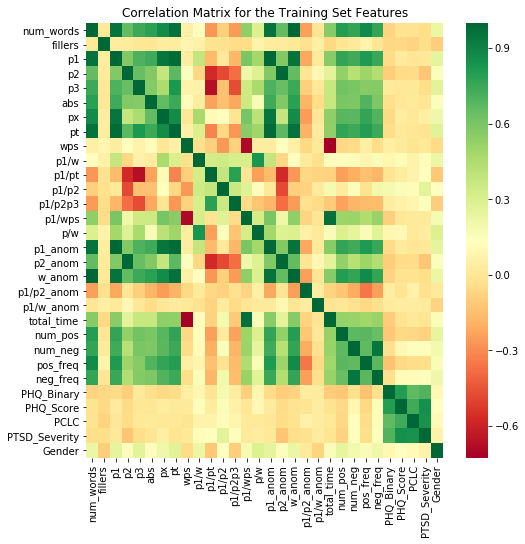

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr_train, xticklabels=corr_train.columns, yticklabels=corr_train.columns, cmap='RdYlGn', ax=ax)
ax.set_title('Correlation Matrix for the Training Set Features')

plt.show()

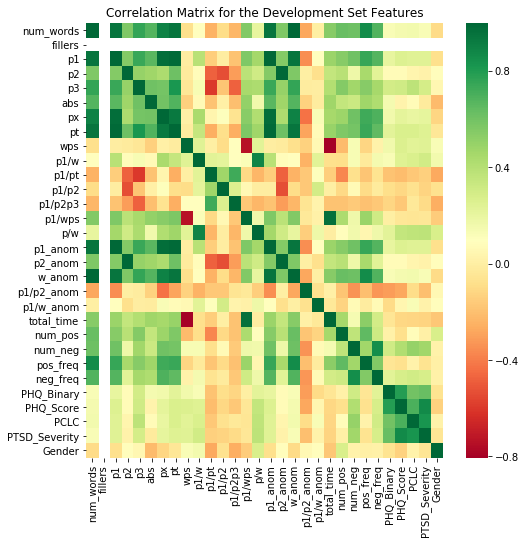

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr_dev, xticklabels=corr_dev.columns, yticklabels=corr_dev.columns, cmap='RdYlGn', ax=ax)
ax.set_title('Correlation Matrix for the Development Set Features')

plt.show()

In [16]:
print(np.unique(dev_features.fillers))

[0]


The fillers feature for the development set does not seem to show up on the correlation matrix. This might be because it only contains 0's.

In [17]:
#print out the actual values for correlation matrix
corr_train[['PHQ_Binary', 'PHQ_Score', 'PCLC', 'PTSD_Severity']].head(25)

,PHQ_Binary,PHQ_Score,PCLC,PTSD_Severity
num_words,-0.076647,-0.017093,-0.016479,-0.033020
fillers,-0.060397,-0.057732,-0.073071,-0.033573
p1,-0.048630,0.023845,0.006869,0.014659
p2,-0.098426,-0.046614,-0.041287,-0.127622
p3,0.020087,0.005991,0.012600,-0.037511
abs,-0.029677,0.006824,0.017509,-0.002399
px,-0.056749,0.034223,0.009499,0.048466
pt,-0.041258,0.016314,0.004919,-0.006762
wps,0.047134,0.017745,-0.008306,0.013302
p1/w,0.085383,0.113998,0.063033,0.119131


In [28]:
corr_dev[['PHQ_Binary', 'PHQ_Score', 'PCLC', 'PTSD_Severity']].head(25)

,PHQ_Binary,PHQ_Score,PCLC,PTSD_Severity
num_words,0.131771,0.152174,0.157860,0.130789
fillers,NaN,NaN,NaN,NaN
p1,0.205842,0.255328,0.244507,0.240249
p2,0.071180,0.070743,0.036092,0.023592
p3,0.295192,0.312590,0.373193,0.291206
abs,0.148434,0.027241,0.070551,-0.019282
px,0.167193,0.223968,0.198092,0.216518
pt,0.225767,0.269160,0.268506,0.249474
wps,0.162996,0.262315,0.237565,0.242434
p1/w,0.130827,0.250294,0.270945,0.302195


The highest correlation between the training set features and any of the metrics we are trying to model was PTSD severity and use of first person singular pronouns to plural pronouns at 0.26. However, you can see that the correlation is weak.

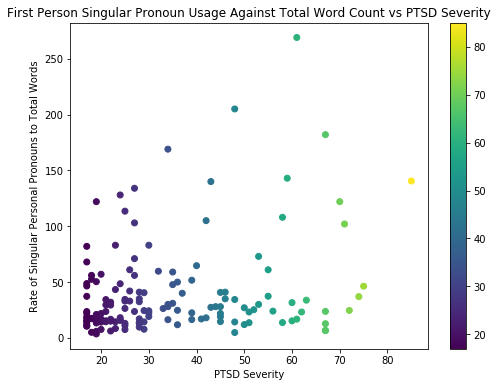

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))

plot = ax.scatter(train_features.PTSD_Severity, train_features['p1/p2'], c=train_features.PTSD_Severity)
ax.set_xlabel('PTSD Severity')
ax.set_ylabel('Rate of Singular Personal Pronouns to Total Words')
ax.set_title('First Person Singular Pronoun Usage Against Total Word Count vs PTSD Severity')

fig.colorbar(plot)

plt.show()

However, there were a number of stronger correlations among the development set specifically with the features num_neg, p/w, and p3.

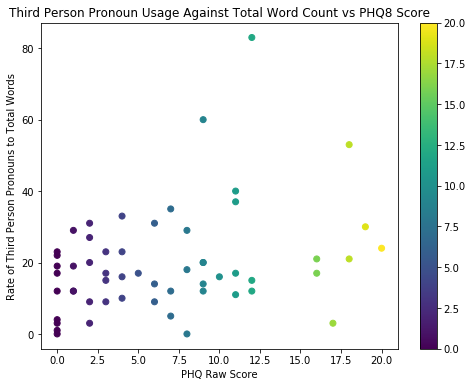

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

plot = ax.scatter(dev_features.PHQ_Score, dev_features.p3, c=dev_features.PHQ_Score)
ax.set_xlabel('PHQ Raw Score')
ax.set_ylabel('Rate of Third Person Pronouns to Total Words')
ax.set_title('Third Person Pronoun Usage Against Total Word Count vs PHQ8 Score')

fig.colorbar(plot)

plt.show()

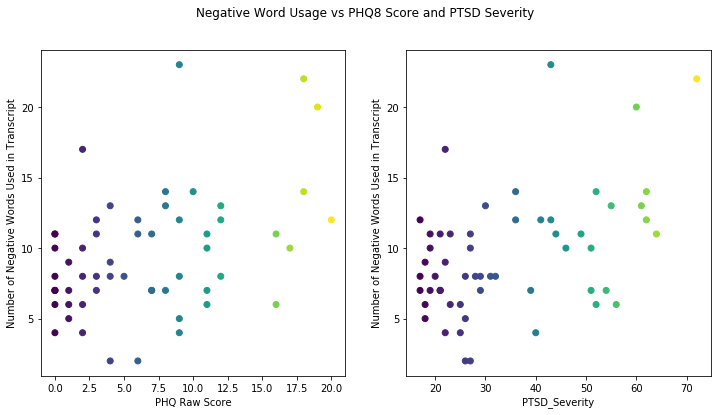

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(dev_features.PHQ_Score, dev_features.num_neg, c=dev_features.PHQ_Score)
ax[0].set_xlabel('PHQ Raw Score')
ax[0].set_ylabel('Number of Negative Words Used in Transcript')

ax[1].scatter(dev_features.PTSD_Severity, dev_features.num_neg, c=dev_features.PTSD_Severity)
ax[1].set_xlabel('PTSD_Severity')
ax[1].set_ylabel('Number of Negative Words Used in Transcript')

plt.suptitle('Negative Word Usage vs PHQ8 Score and PTSD Severity')

plt.show()

These correlations show that there is definitely an improvement in the information that we can get in this version of the dataset to that of the last iteration. However, it is concerning that the correlations found for the training and development sets are so different. This speaks to the different distributions of the two subsets of the data, and does not bode well for trying to build a model that can make predictions given the data that we have.